### Code & Plot References
AstroML: http://www.astroml.org/book_figures/chapter8/index.html#book-fig-chapter8

UW GitHub: https://github.com/gtrichards/PHYS_T480/blob/master/Regression2.ipynb

Jupyter Notebook Markdown Cheat Sheet: http://datascience.ibm.com/blog/markdown-for-jupyter-notebooks-cheatsheet/

In [55]:
%matplotlib inline
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

from sklearn.gaussian_process import GaussianProcess

# Turn off annoying sklearn Deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=30, usetex=True)

# <center><font color=blue> Regression and Model Fitting</font></center>
## <center><font color=green> Jennifer Kadowaki </font></center>

### <center><font color=red> AST 502 - Data Mining and Machine Learning in Astronomy </font></center>
### <center><font color=red> Lecture 15 — Wednesday October 25, 2017 </font></center>

# <font color=blue> $\S8.7.$ Non-linear Regression </font>

### Review from Monday's Lecture: <font color=red> What are Linear Models? </font>
<font color=purple> **Linear models** </font> are characterized by a function composed of a linear combination of <font color=purple> **model parameters** </font>: $$f(x | \theta) = \sum\limits_{i=1}^k \theta_i g_i(x)$$
Linear regression from both (1) the least squares and (2) maximum likelihood with Gaussian errors perspectives result in the **normal equation** to find model parameters. **Regularization** (which modifies the normal equation) prevents overfitting by penalizing model complexity.

### <font color=red> What are Non-linear Models? </font>
<font color=purple> **Non-linear models** </font> are characterized by a function composed of a non-linear combination of <font color=purple> **model parameters** </font>: $$f(x | \theta) \neq \sum\limits_{i=1}^k \theta_i g_i(x)$$


### Example: <font color=red>Which Models are Linear? Non-linear?</font>
1. $f(x | m, b) = mx + b$
2. $f(x | m, b) = mx + b^2$
3. $f(x | m, b) = m \sin(x) + b$
4. $f(x | m, b) = m x^2 + b x$
5. $f(x | m, b) = m e^{bx}$
6. $f(x | m, b) = m e^{-x} + b$

### <font color=red> Linearizing Models </font>
Often, we can **force** data to correspond to a linear model by using a <font color=purple>**coordinate transform**</font>. For instance, consider the exponential growth/decay equation: $y = m e^{bx}$. We can linearize this equation by taking the natural log of either sides:
$$\log(y) = \log(m e^{bx}) = \log(m) + bx$$

When we define a new response variable $z = \log(y)$ and a new model parameter $n = \log(m)$, we can perform **linear regression** on the linearized equation $$z = n + bx$$ using the normal equation (from last lecture) to estimate the model parameters $(n,b)$.

However, linearizing a model can pose several **caveats: (1) <font color=purple> linearization may introduce non-Gaussian uncertainties/errors</font> and (2) <font color=purple>if we know the theoretical form of our non-linear model, we may want to directly fit the data to our model</font>**.  As such, we must consider other non-linear regression approaches.

### <font color=red> $\Lambda$CDM: The Cosmological Model </font>

In the last lecture, we naively applied linear regression to observed measurements of the distance modulus $\mu$ and the redshift $z$ of high-z SN1A. However, let's revisit this example using our knowledge of cosmology!

@pickle_results: using precomputed results from 'mu_z_nonlinear.pkl'


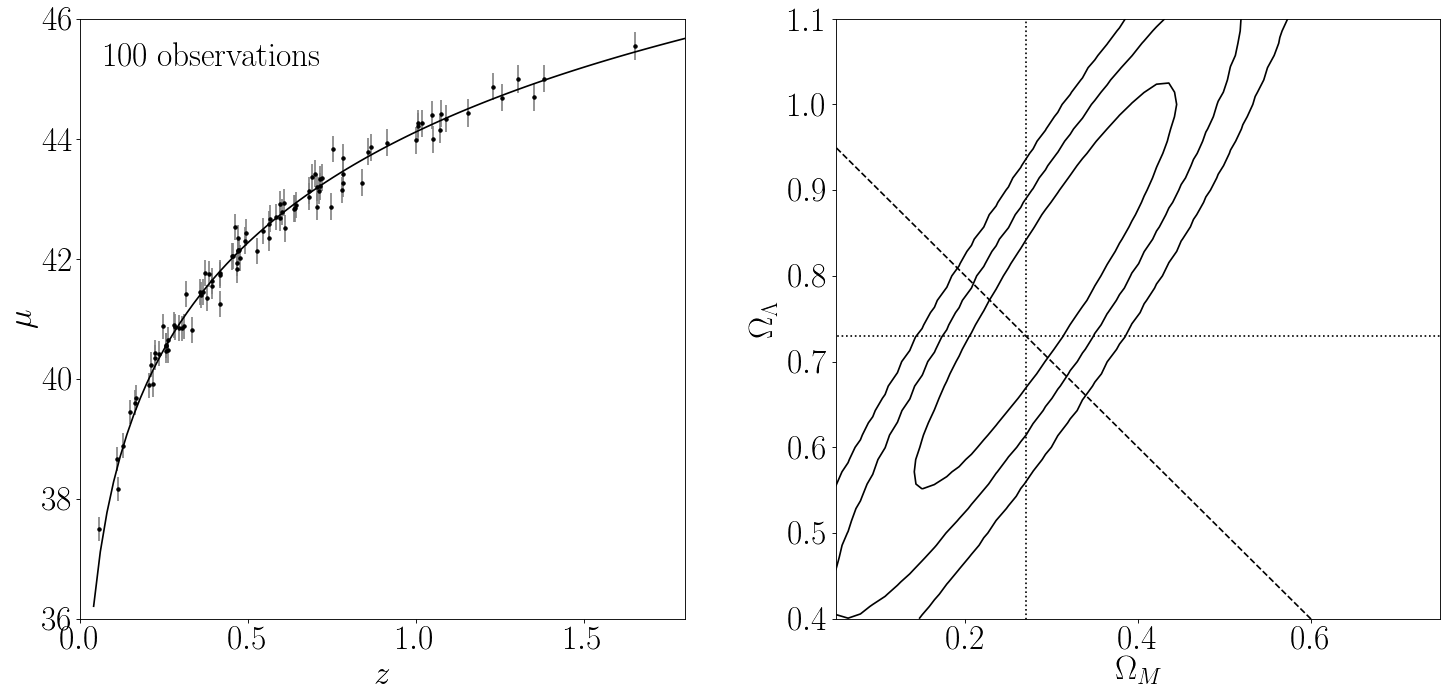

In [59]:
# Author: Jake VanderPlas
# License: BSD

from astroML.datasets import generate_mu_z
from astroML.cosmology import Cosmology
from astroML.plotting.mcmc import convert_to_stdev
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3, dmu_0=0.05, dmu_1=0.004, random_state=1)


#------------------------------------------------------------
# define a log likelihood in terms of the parameters
#  beta = [omegaM, omegaL]
def compute_logL(beta):
    cosmo = Cosmology(omegaM=beta[0], omegaL=beta[1])
    # mu_pred = np.array(map(cosmo.mu, z_sample))         #---- Use for Python 2
    mu_pred = np.array(list(map(cosmo.mu, z_sample)))     #---- Use for Python 3
    return - np.sum(0.5 * ((mu_sample - mu_pred) / dmu) ** 2)


#------------------------------------------------------------
# Define a function to compute (and save to file) the log-likelihood
@pickle_results('mu_z_nonlinear.pkl')
def compute_mu_z_nonlinear(Nbins=50):
    omegaM = np.linspace(0.05, 0.75, Nbins)
    omegaL = np.linspace(0.4, 1.1, Nbins)

    logL = np.empty((Nbins, Nbins))

    for i in range(len(omegaM)):
        #print '%i / %i' % (i + 1, len(omegaM))
        for j in range(len(omegaL)):
            logL[i, j] = compute_logL([omegaM[i], omegaL[j]])

    return omegaM, omegaL, logL

omegaM, omegaL, res = compute_mu_z_nonlinear()
res -= np.max(res)


#------------------------------------------------------------
# Plot the results
#fig = plt.figure(figsize=(5, 2.5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)

# left plot: the data and best-fit
ax = fig.add_subplot(121)
whr = np.where(res == np.max(res))
omegaM_best = omegaM[whr[0][0]]
omegaL_best = omegaL[whr[1][0]]
cosmo = Cosmology(omegaM=omegaM_best, omegaL=omegaL_best)

z_fit = np.linspace(0.04, 2, 100)
# mu_fit = np.asarray(map(cosmo.mu, z_fit))             #---- Use for Python 2
mu_fit = np.asarray(list(map(cosmo.mu, z_fit)))         #---- Use for Python 3


ax.plot(z_fit, mu_fit, '-k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')

ax.set_xlim(0, 1.8)
ax.set_ylim(36, 46)

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.text(0.04, 0.96, "%i observations" % len(z_sample),
        ha='left', va='top', transform=ax.transAxes)

# right plot: the likelihood
ax = fig.add_subplot(122)

ax.contour(omegaM, omegaL, convert_to_stdev(res.T),
           levels=(0.683, 0.955, 0.997), colors='k')

ax.plot([0, 1], [1, 0], '--k')
ax.plot([0, 1], [0.73, 0.73], ':k')
ax.plot([0.27, 0.27], [0, 2], ':k')

ax.set_xlim(0.05, 0.75)
ax.set_ylim(0.4, 1.1)

ax.set_xlabel(r'$\Omega_M$')
ax.set_ylabel(r'$\Omega_\Lambda$')

plt.show()


#### (Left):   <font color=purple>Distance Modulus $\mu$  vs.  Redshifts of High-z SN1A</font>
The redshift of SN1A are measured using cross-correlation using a template spectra.
Distance moduli can be computed by the taking the difference between the apparant and the absolute magnitudes of these standard candles, such that $\mu = m - M$.

We build our model from our $\Lambda$CDM cosmological framework.
Distance moduli: $$\mu = 5 \log \left(\frac{D_L}{10 \, \text{pc}}\right)$$,
such that the luminosity distance is $D_L = (1+z) D_M$ where $D_M$ is the transverse comoving distance. In a flat universe, the transverse comoving distance is equal to the line-of-sight comoving distance $D_c$:
$$D_c = \frac{c}{H_0} \int\limits_0^z \frac{dz'}{\sqrt{\Omega_M (1+z')^3 + \Omega_\Lambda)}}$$
for a flat universe.


#### (Right):   <font color=purple>Contour Plot for Cosmological Parameters</font>
The best-fit parameters for $\Omega_M$ and $\Omega_\Lambda$ maximizes our posterior $p(\Omega_M, \Omega_\Lambda | z, I)$ and minimizes the average squared loss between the observed and model predicted $\mu$. Assuming uniform priors for model parameters, the contours represents $1\sigma, 2\sigma$, and $3\sigma$ regions.

From our theoretical framework of cosmology, we have built a non-linear model parametrized by the energy density parameters for matter $\Omega_M$ and for $\Lambda$ (i.e. dark energy) $\Omega_\Lambda$. To estimate $\Omega_M$ and $\Omega_\Lambda$, we need to maximize the posterior:

$$p(\Omega_M, \Omega_\Lambda | z, I) \propto \prod\limits_{i=1}^n \frac{1}{\sigma_i \sqrt{2\pi}} \exp \left(\frac{-(\mu_i - \mu(z_i | \Omega_M, \Omega_\Lambda))^2}{2 \sigma_i^2}\right) p(\Omega_M, \Omega_\Lambda)$$
where $\mu$ is the distance modulus and $z$ is redshift of supernovae.

### <font color=red> Levenberg-Marquardt (LM) Algorithm </font>

Levenberg-Marquardt algorithm is a combination of **gradient descent** & **Gauss-Newtonian method** to optimize the **maximum likelihood estimation** by searching for the **sum of squares minima**.

If we express our regression function as a Taylor series expansion, (to first order) we have:
$$f(x_i | \theta) = f(x_i | \theta_0) + J d\theta$$
where $J = \partial f(x_i | \theta)/ \partial \theta$ is the Jacobian and $\theta_0$ is the initial guess for regression parameters, and $d\theta$ is the perturbation in regression parameters.

LM minimizes the sum of square errors:
$$\sum\limits_i \left[y_i - f(x_i | \theta_0) - J_i d\theta \right]^2$$

for perturbations $d\theta$. The minimization results in an update relation given by:
$$\left[J^\top C^{-1} J + \lambda \text{diag} \left(J^\top C^{-1} J\right)\right] d\theta = J^\top C^{-1} \left[Y - f(X | \theta)\right]$$
where $\lambda$ acts as a damping paramter. (Large $\lambda$ LM approximates gradient descent. Small $\lambda$ approximates the Gauss-Newton method, which assumes a quadratic function to minimize parameters.) The term $\text{diag} \left(J^\top C^{-1} J\right)$ improves convergence by ensuring the update of $d\theta$ is largest along directions where the gradient is the smallest.

This iterative algorithm continues until the step size or change in likelihood values achieves some pre-determined threshold value.

#### Example: <font color=purple> Using the Levenberg-Marquardt Algorithm in $\tt{scipy.optimize.leastsq}$  </font>
Python routines in submodule $\tt{scipy.optimize}$ can optimize both linear and non-linear equations. In particular, the LM algorithm is used in the submodule's least squares estimate routine: $\tt{scipy.optimize.leastsq}$.

The following example demonstrates how to obtain estimates of the first 6 terms in the Taylor expansion of the sine function: $y = \sin x \approx \sum\limits_n a_n x^n$.

In [72]:
from scipy import optimize

x = np.linspace(-3, 3, 100)  # 100 values between -3 and 3

def taylor_err(a, x, f):
    p = np.arange(len(a))[:, np.newaxis]  # column vector
    return f(x) - np.dot(a, x ** p)

a_start = np.zeros(6)  # starting guess
a_best, flag = optimize.leastsq(taylor_err, a_start, args=(x, np.sin))

# <font color=blue> $\S8.8.$ Uncertainties in Data </font>

Linear regression makes several assumptions:
   - Data has Gaussian-distributed uncertainties
   - Independent variables are error-free
   - We have control over model complexity
   - We can express the likelihood as linear functions.

In the real world, these assumptions often do not hold.

## <font color=green> $\S8.8.1.$ Total Least Squares: Uncertainties in the Dependent and Independent Axes </font>
Bias introduced to regression coefficients when errors are present in our independent variable.

Simple demonstration on a model characterized by a line:
$$y_i^* = \theta_0 + \theta_1 x_i^*$$

If the observed $x$ and $y$ are relatively noisy:
$$x_i = x_i^* + \delta_i$$
$$y_i = y_i^* + \epsilon_i$$

When we solve for $y$, the uncertainty in $x$ becomes a part of our regression equation and scales with regression coefficients.
$y = \theta_0 + \theta_1 (x_i - \delta_i) + \epsilon_i$.


### Example: <font color=red>  </font>
(In Fig 1, we obsered some uncertainty in our response variable $\mu$ with extremely accurate target variable (z) derived from spectroscopic redshifts. A real life example would be if we had to estimate redshifts with photometric information, our uncertainties on the target variable will increase drastically.)

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


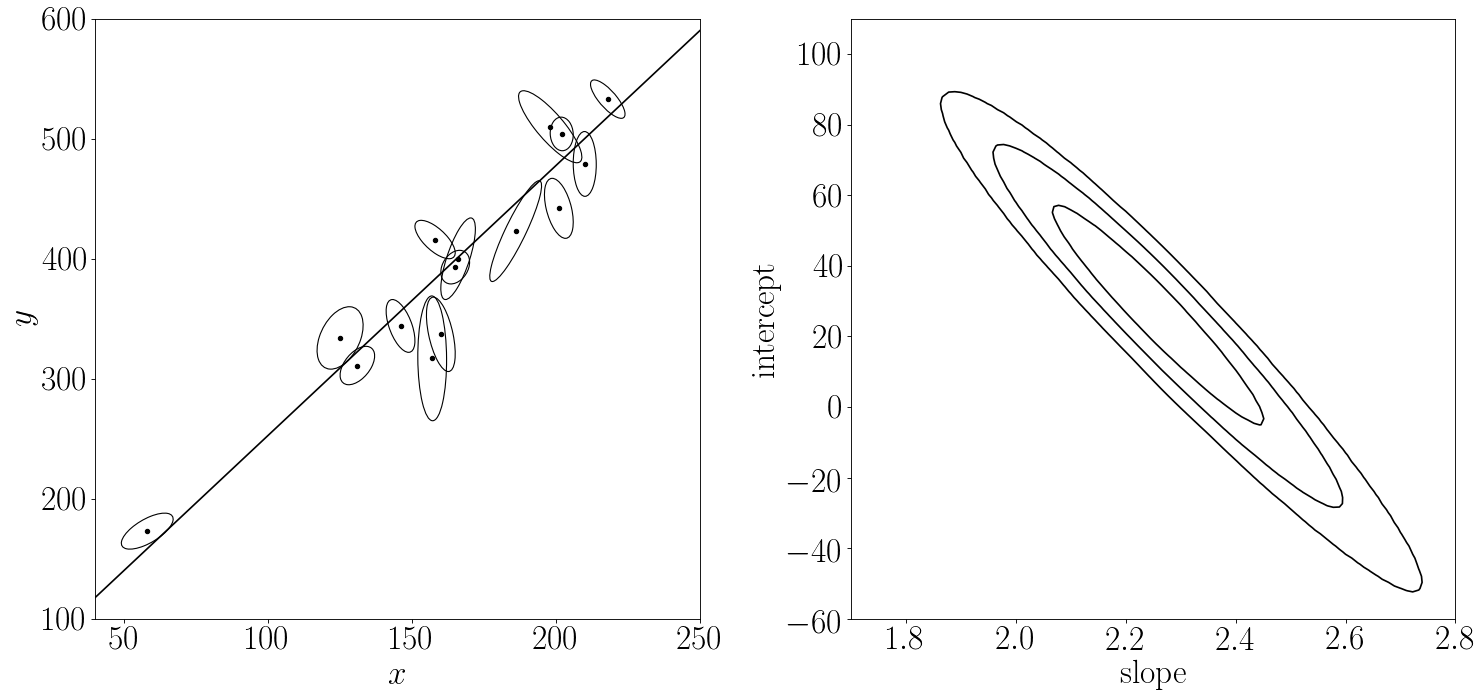

In [36]:
# Author: Jake VanderPlas
# License: BSD

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test


#------------------------------------------------------------
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

#------------------------------------------------------------
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1])

#------------------------------------------------------------
# Plot the data and fits
#fig = plt.figure(figsize=(5, 2.5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=15)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(1.7, 2.8, 100)
b = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

plt.show()

# <font color=blue> $\S8.9.$ Regressions that are Robust to Outliers </font>

### Motivation: <font color=red> Why should We Care about Outliers? </font>

### <font color=red> How to Deal with Outliers: </font>
1. Models errors into the likelihood if we know the errors for our samples

2. If we do not know errors, model errors as a mixture model or assume some form less sensitive to outliers

3. Outlier Rejection (aka: "Sigma Clipping" in astronomy)
Iterative pruning.
Formalism: Least-trimmed squares --- searches for a subset of $k$ points for which to minimize $\sum\limits_i^K (y_i - \theta_i x_i)^2$. Expensive for large $N$.

4. Theil-Sen  / Kendall  Robust line-fit method
regression is determined by median of slope, calculated from all pairs of points
offset/zero point is computed from $\theta_0 = y_i - \theta_1 x_i$ given the slope 
simple to estimate, scales ot large numbers

5. Maximum Likelihood-type Estimators (M-estimators)
class of modifiers that modify likelihood estimator to be less sensitive than L_2 norm.




### <font color=red> Huber Loss Function </font>
HLF is a common robust M-estimator. The Huber estimator minimizes


$$\sum\limits_{i=1}^N e(y_i | y)$$

where $e(y_i | y)$ is modeled as

$$\phi(t) = \left\{ \begin{array}{ll}
                    t^2/2          &   \text{if } |t| \leq c \\
                    c|t| - c^2/2   &   \text{if } |t| \geq c
                    \end{array}
            \right.$$


#### Graphical Depiction of the Huber Loss Function

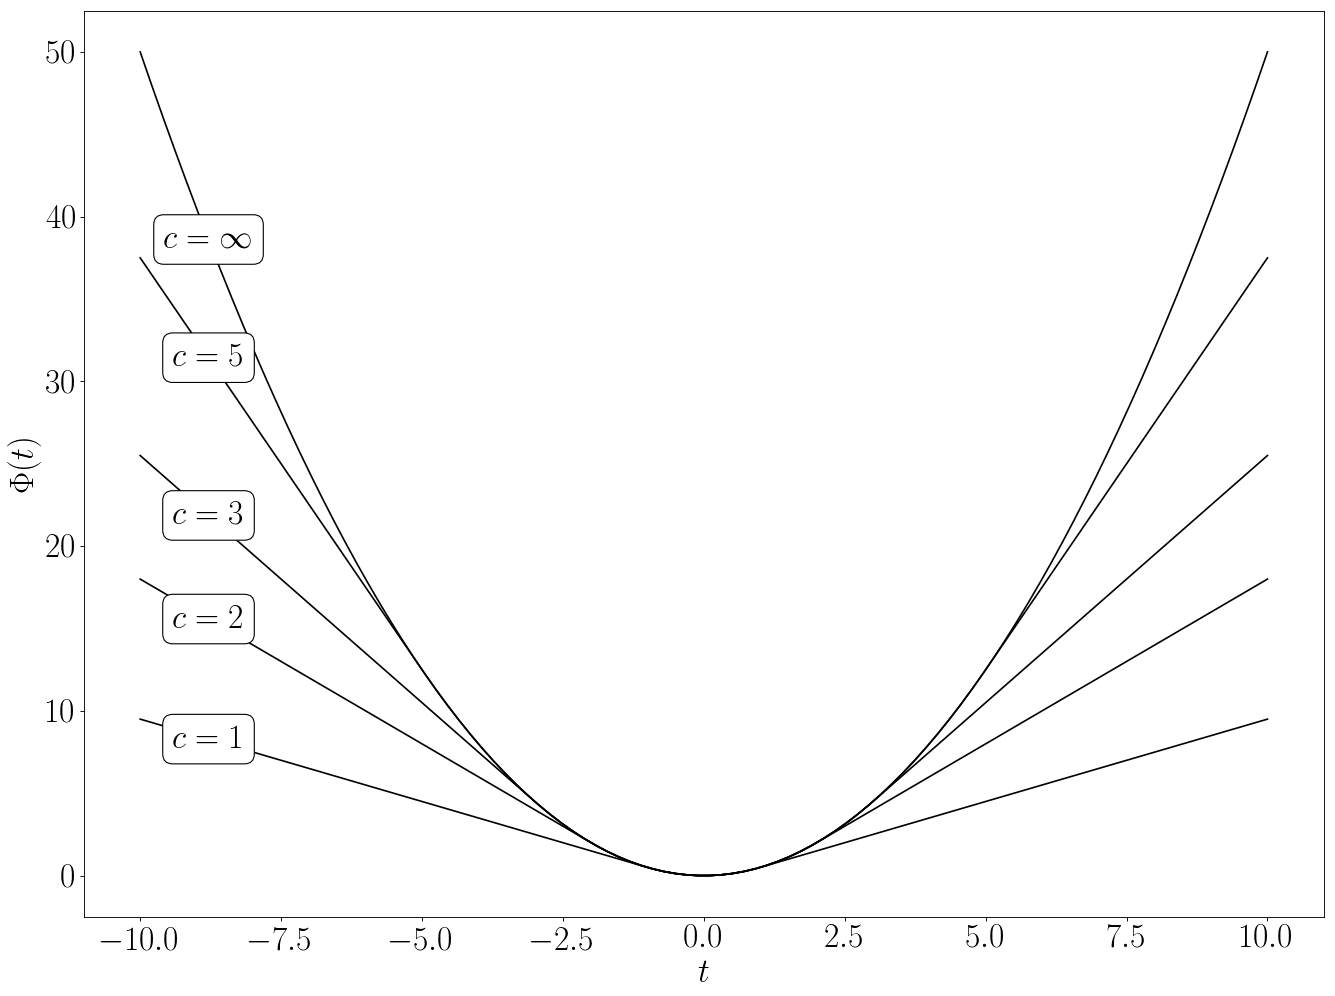

In [38]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# Define the Huber loss
def Phi(t, c):
    t = abs(t)
    flag = (t > c)
    return (~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t)

#------------------------------------------------------------
# Plot for several values of c
#fig = plt.figure(figsize=(5, 3.75))             #---- Figure is too small
fig = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)

x = np.linspace(-10, 10, 100)

for c in (1, 2, 3, 5, 1000):
    y = Phi(x, c)
    ax.plot(x, y, '-k')

    if c > 10:
        s = r'\infty'
    else:
        s = str(c)

    ax.text(x[6], y[6], '$c=%s$' % s,
            ha='center', va='center',
            bbox=dict(boxstyle='round', ec='k', fc='w'))

ax.set_xlabel('$t$')
ax.set_ylabel(r'$\Phi(t)$')

plt.show()


Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115
[   1.07674745  213.27350923]
[  1.96473118  70.00573832]


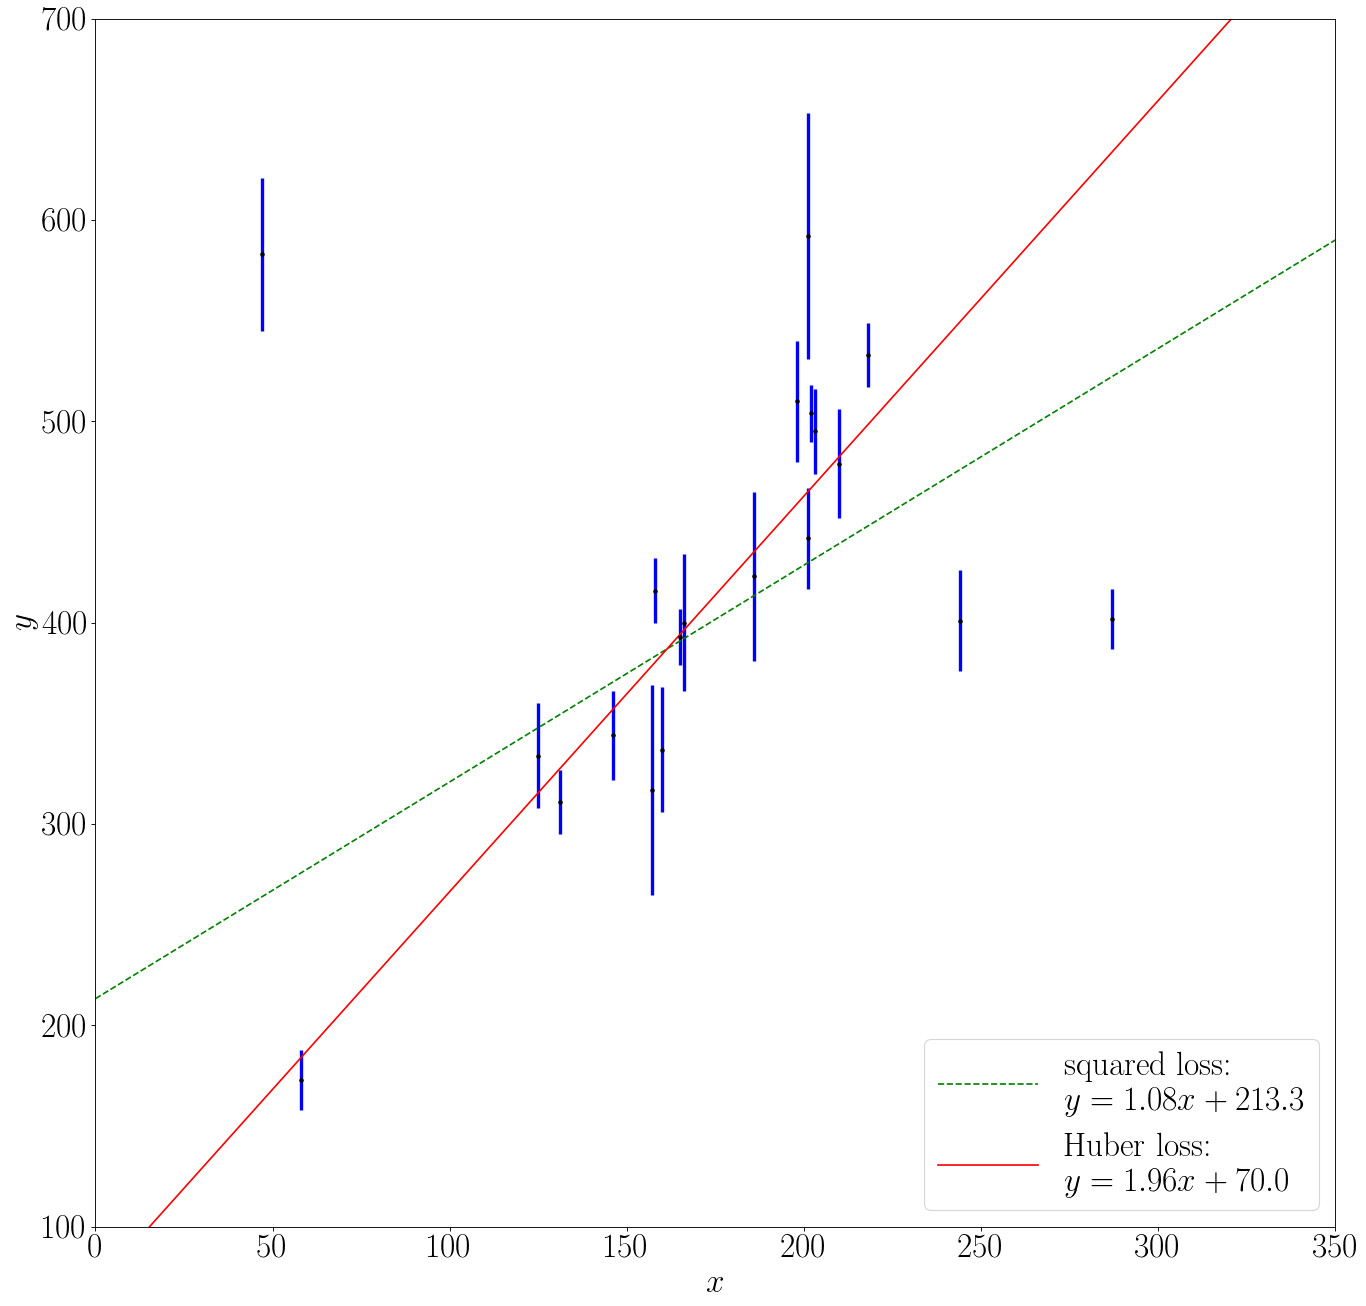

In [43]:
# Author: Jake VanderPlas
# License: BSD

from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']


# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)


# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    flag = t > c
    return np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)
f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_huber = optimize.fmin(f_huber, beta0)

print(beta_squared)
print(beta_huber)

#------------------------------------------------------------
# Plot the results
#fig = plt.figure(figsize=(5, 5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--g',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-r',
        label="Huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
ax.legend(loc=4)

ax.errorbar(x, y, dy, fmt='.k', lw=3, ecolor='blue')

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## <font color=green> $\S8.9.1.$ Bayesian Outlier Methods </font>

Let's assume the data are drawn from two Gaussians distributions (one for the function and the other for the outliers

$$p(\left.\{y_i\} \right| \{x_i\}, \{\sigma_i\}, \theta_0, \theta_1, \mu_b, V_b, p_b) \propto \prod\limits_{i=1}^N \left[ \frac{1-p_b}{\sqrt{2\pi \sigma_i^2}} \exp \left(- \frac{(y_i - \theta_1 x_i - \theta_0)^2}{2 \sigma_i^2} \right) + \frac{p_b}{\sqrt{2\pi (V_b + \sigma_i^2)}} \exp \left(- \frac{(y_i-\mu_b)^2}{2(V_b + \sigma_i^2)} \right) \right]$$

$$p(\left.\{y_i\} \right| \{x_i\}, \{\sigma_i\}, \{g_i\}, \theta_0, \theta_1, \mu_b, V_b) \propto \prod\limits_{i=1}^N \left[ \frac{g_i}{\sqrt{2\pi \sigma_i^2}} \exp \left(- \frac{(y_i - \theta_1 x_i - \theta_0)^2}{2 \sigma_i^2} \right) + \frac{1 - g_i}{\sqrt{2\pi (V_b + \sigma_i^2)}} \exp \left(- \frac{(y_i-\mu_b)^2}{2(V_b + \sigma_i^2)} \right) \right]$$

$V_b$ is the variance of the outlier distribution. If we use MCMC we can marginalize over the nuisance parameters $p_b$, $V_b$, $\mu_b$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.

**Top Left**: Data with 3 obvious outlier points. Not accounting for the outliers gives the dotted line and the model parameters shown in the top right. Accounting for the outliers with two different methods gives the dashed and solid lines in the top left and the parameter fits given in the bottom 2 plots.


 [-----------------100%-----------------] 25000 of 25000 complete in 22.1 sec

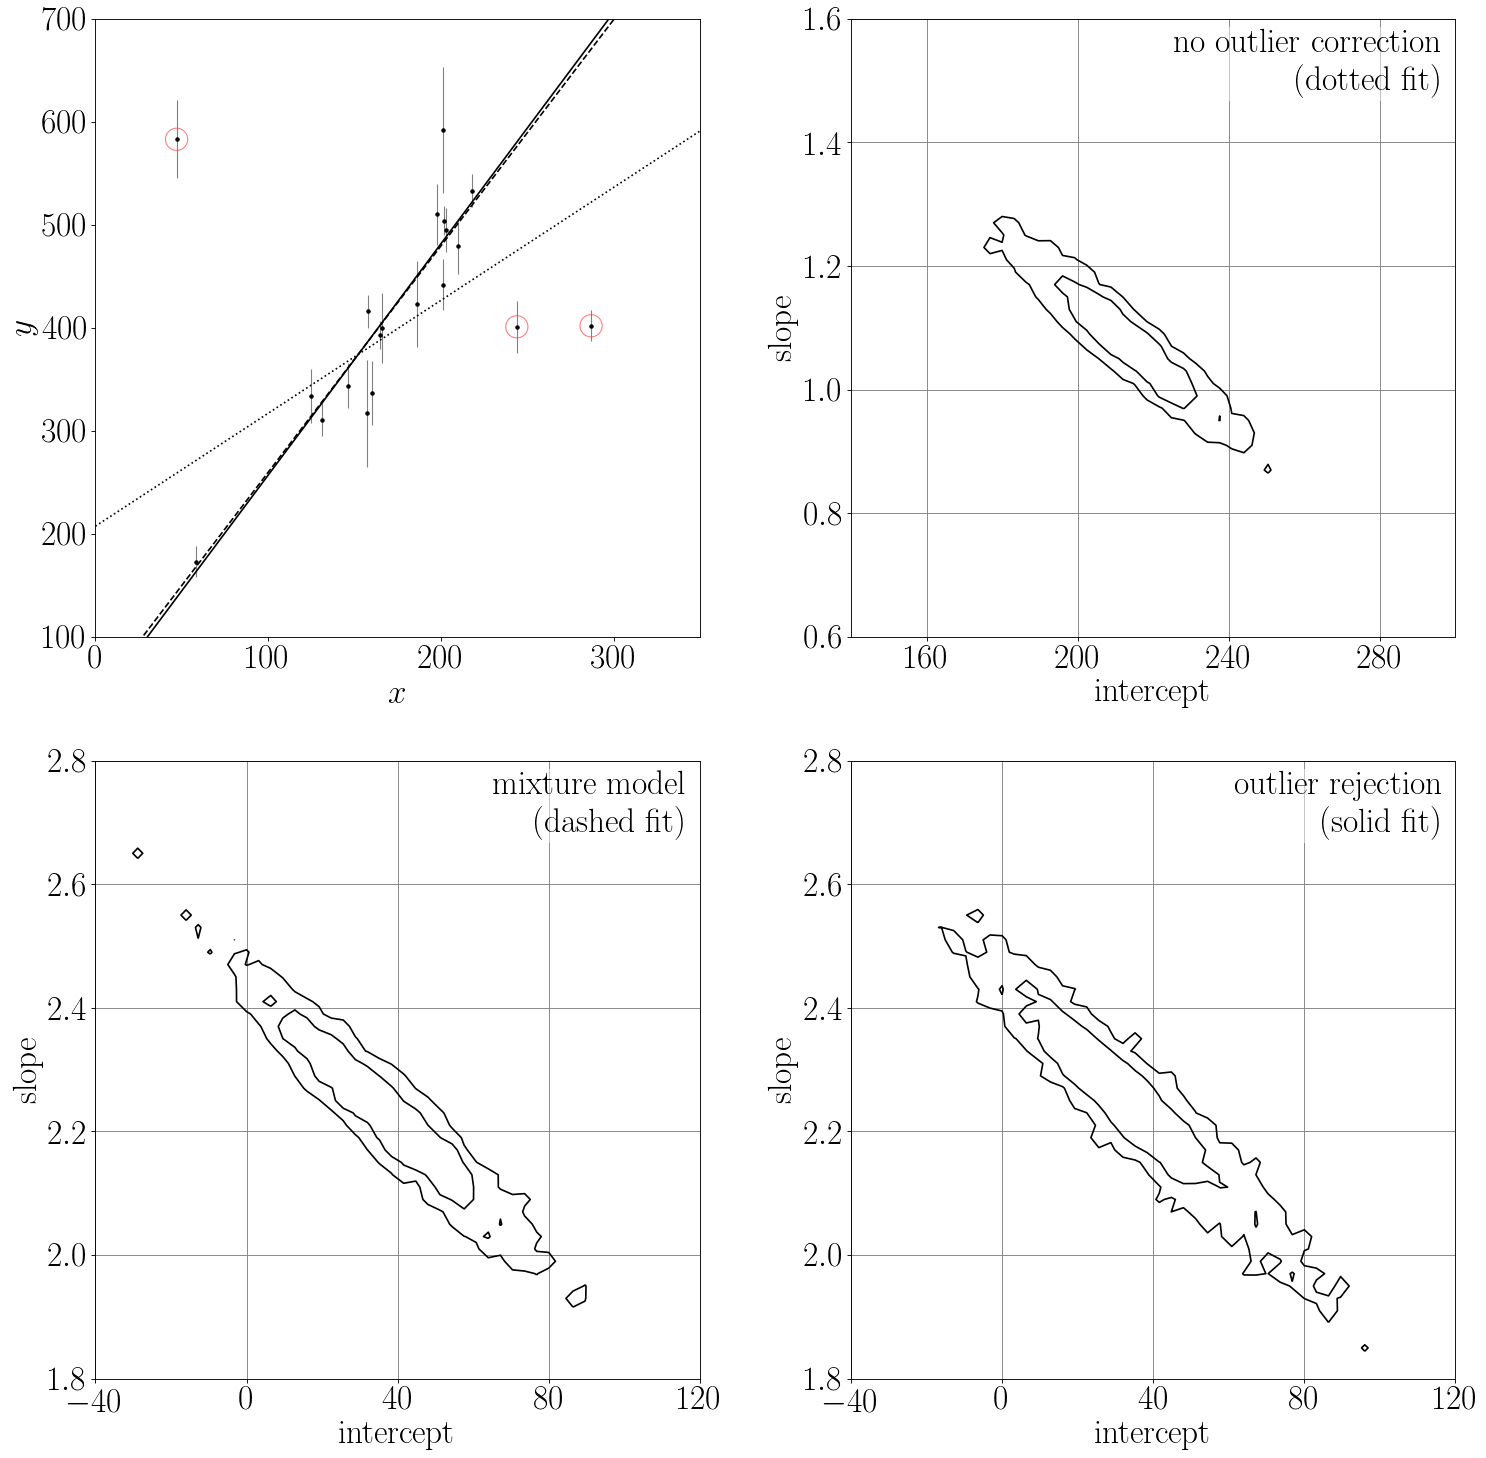

In [46]:
# Author: Jake VanderPlas
# License: BSD

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

np.random.seed(0)

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
xi = data['x']
yi = data['y']
dyi = data['sigma_y']


#----------------------------------------------------------------------
# First model: no outlier correction
# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M0(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M0(xi=xi, beta=beta_M0):
    slope, intercept = beta
    return slope * xi + intercept

y = pymc.Normal('y', mu=model_M0, tau=dyi ** -2,
                observed=True, value=yi)

M0 = dict(beta_M0=beta_M0, model_M0=model_M0, y=y)


#----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al

# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M1(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M1(xi=xi, beta=beta_M1):
    slope, intercept = beta
    return slope * xi + intercept

# uniform prior on Pb, the fraction of bad points
Pb = pymc.Uniform('Pb', 0, 1.0, value=0.1)

# uniform prior on Yb, the centroid of the outlier distribution
Yb = pymc.Uniform('Yb', -10000, 10000, value=0)

# uniform prior on log(sigmab), the spread of the outlier distribution
log_sigmab = pymc.Uniform('log_sigmab', -10, 10, value=5)


@pymc.deterministic
def sigmab(log_sigmab=log_sigmab):
    return np.exp(log_sigmab)


# set up the expression for likelihood
def mixture_likelihood(yi, model, dyi, Pb, Yb, sigmab):
    """Equation 17 of Hogg 2010"""
    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi
            * np.exp(-0.5 * (yi - model) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return np.sum(np.log((1 - Pb) * L_in + Pb * L_out))

MixtureNormal = pymc.stochastic_from_dist('mixturenormal',
                                          logp=mixture_likelihood,
                                          dtype=np.float,
                                          mv=True)

y_mixture = MixtureNormal('y_mixture', model=model_M1, dyi=dyi,
                          Pb=Pb, Yb=Yb, sigmab=sigmab,
                          observed=True, value=yi)

M1 = dict(y_mixture=y_mixture, beta_M1=beta_M1, model_M1=model_M1,
          Pb=Pb, Yb=Yb, log_sigmab=log_sigmab, sigmab=sigmab)


#----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M2(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M2(xi=xi, beta=beta_M2):
    slope, intercept = beta
    return slope * xi + intercept

# qi is bernoulli distributed
# Note: this syntax requires pymc version 2.2
qi = pymc.Bernoulli('qi', p=1 - Pb, value=np.ones(len(xi)))


def outlier_likelihood(yi, mu, dyi, qi, Yb, sigmab):
    """likelihood for full outlier posterior"""
    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    logL_in = -0.5 * np.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * np.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in

OutlierNormal = pymc.stochastic_from_dist('outliernormal',
                                          logp=outlier_likelihood,
                                          dtype=np.float,
                                          mv=True)

y_outlier = OutlierNormal('y_outlier', mu=model_M2, dyi=dyi,
                          Yb=Yb, sigmab=sigmab, qi=qi,
                          observed=True, value=yi)

M2 = dict(y_outlier=y_outlier, beta_M2=beta_M2, model_M2=model_M2,
          qi=qi, Pb=Pb, Yb=Yb, log_sigmab=log_sigmab, sigmab=sigmab)

#------------------------------------------------------------
# plot the data
#fig = plt.figure(figsize=(5, 5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(xi, yi, dyi, fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
models = [M0, M1, M2]
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']


x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, M in enumerate(models):
    S = pymc.MCMC(M)
    S.sample(iter=25000, burn=5000)
    trace = S.trace('beta_M%i' % i)

    H2D, bins1, bins2 = np.histogram2d(trace[:, 0], trace[:, 1], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        qi = S.trace('qi')[:]
        Pi = qi.astype(float).mean(0)
        outlier_x = xi[Pi < 0.32]
        outlier_y = yi[Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace[:, 1], trace[:, 0], bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.98, 0.98, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

# <font color=blue> $\S8.10.$ Gaussian Process Regression </font>

A Gaussian Process (GP) is a collection of random variables in a parameter space for which any subset can be defined by a joint Gaussian distribution.

**Top Left**: We have drawn some random distributions from a Gaussian Basis. Specifically, we have put down evenly spaced Gaussians across the parameter space, that have width of $h$ and covariance given by
$$\text{Cov}(x_1, x_2; h) = \exp \left( \frac{-(x_1 - x_2)^2}{2 h^2} \right)$$


For a given bandwidth we can obviously define an infinite set of such functions.


**Top Right**: We constrain these functions by selecting those that pass though a given set of points using the posterior:
$$p(f_j | \{x_i, y_i, \sigma_i \}, x_j^*)$$


**Bottom**: The bottom panels show the result for the same points with error bars and 20 noisy points drawn from $y=\cos(x)$. You can perhaps see how this might be useful.

best-fit theta = 2.82307963627


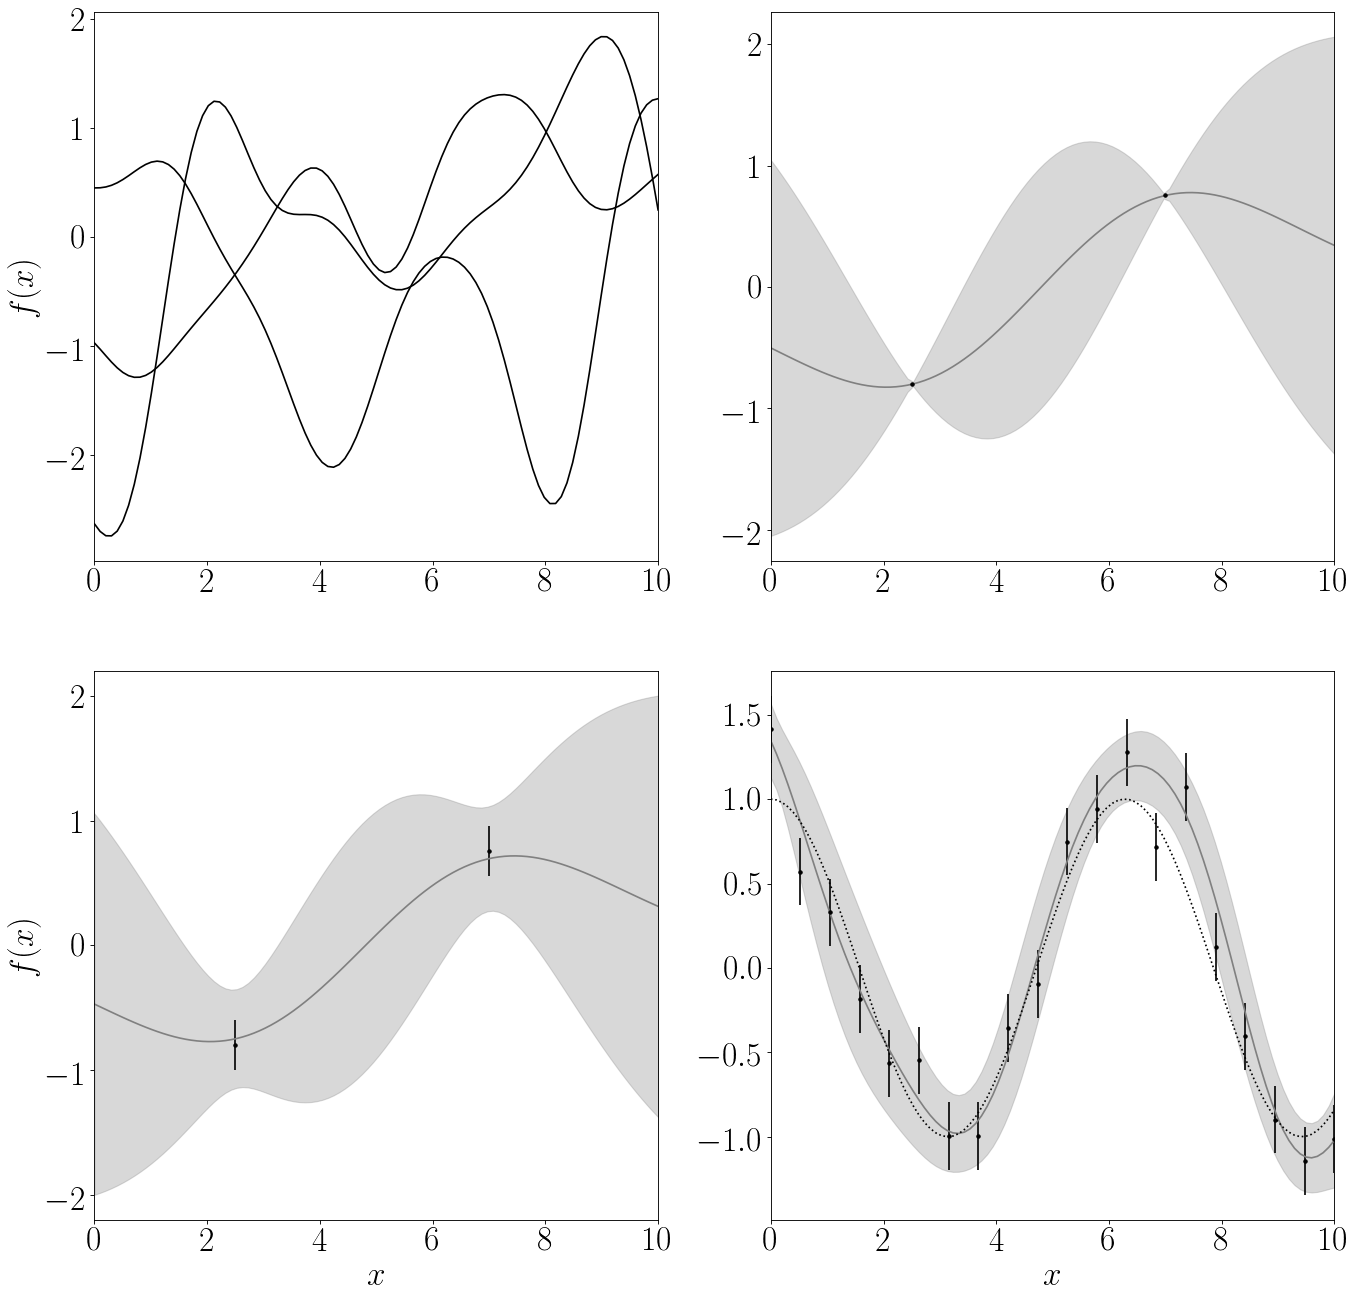

In [73]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
gp1 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0)
gp1.fit(x1[:, None], y1)
f1, MSE1 = gp1.predict(x[:, None], eval_MSE=True)
f1_err = np.sqrt(MSE1)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget" can be specified.  The diagonal of the
#  assumed covariance matrix is multiplied by the nugget.  This is
#  how the error on inputs is incorporated into the calculation
dy2 = 0.2
gp2 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      nugget=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, MSE2 = gp2.predict(x[:, None], eval_MSE=True)
f2_err = np.sqrt(MSE2)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)
gp3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      thetaL=0.01, thetaU=10.0,
                      nugget=(dy3 / y3) ** 2,
                      random_state=0)
gp3.fit(x3[:, None], y3)
f3, MSE3 = gp3.predict(x[:, None], eval_MSE=True)
f3_err = np.sqrt(MSE3)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.theta_[0])


#------------------------------------------------------------
# Plot the diagrams
#fig = plt.figure(figsize=(5, 5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

For GP regression, we want to estimate the value and variance of a new set of points given an input data set. This is equivalent to averaging over all functions that pass through our input data.
The covariance matrix is

$  K = \begin{pmatrix}
    K_{11} && K_{12} \\
    K_{12}^T && K_{22}
  \end{pmatrix},
$

where $K_{11}$ is the covariance between the input points $x_i$ with observational errors $\sigma_i^2$ added in quadrature to the diagonal, $K_{12}$ is the cross-covariance between the input points $x_i$ and the unknown points $x^\ast_j$, and $K_{22}$ is the covariance between the unknown points $x_j^\ast$.

Then for observed vectors $\vec{x}$ and $\vec{y}$, and a vector of unknown points $\vec{x}^\ast$, it can be shown that the posterior is given by


$$p(f_j | \{x_i, y_i, \sigma_i \}, x_j^*) = \mathcal{N}(\mu, \Sigma)$$
where $\mu = K_{12} K_{11}^{-1} \vec{y}$ and $\Sigma = K_{22} -  K_{12}^\top K_{11}^{-1} K_{12}$


$\mu_j$ gives the expected value $\bar{f}^\ast_j$ of the result, and $\Sigma_{jk}$ gives the error covariance between any two unknown points. It gives the value and uncertainty of a predicted point.

Note that the physics of the underlying process enters through the assumed form of the covariance function

### The Scikit-Learn GaussianProcess implementation looks like:

In [14]:
X = np.random.random((100, 2))  # 100 pts in 2 dimensions
y = np.sin(10 * X[:,0] + X[:,1])
gp = GaussianProcess(corr='squared_exponential')
gp.fit(X, y)
y_pred, dy_pred = gp.predict(X, eval_MSE=True)

### Example: <font color=red> Gaussian Process Regression on SN1A data</font>
Advantages: Not only do you get a fit, you get errors and can tell where the fit is good and where it is poor.

[ 0.18093568]


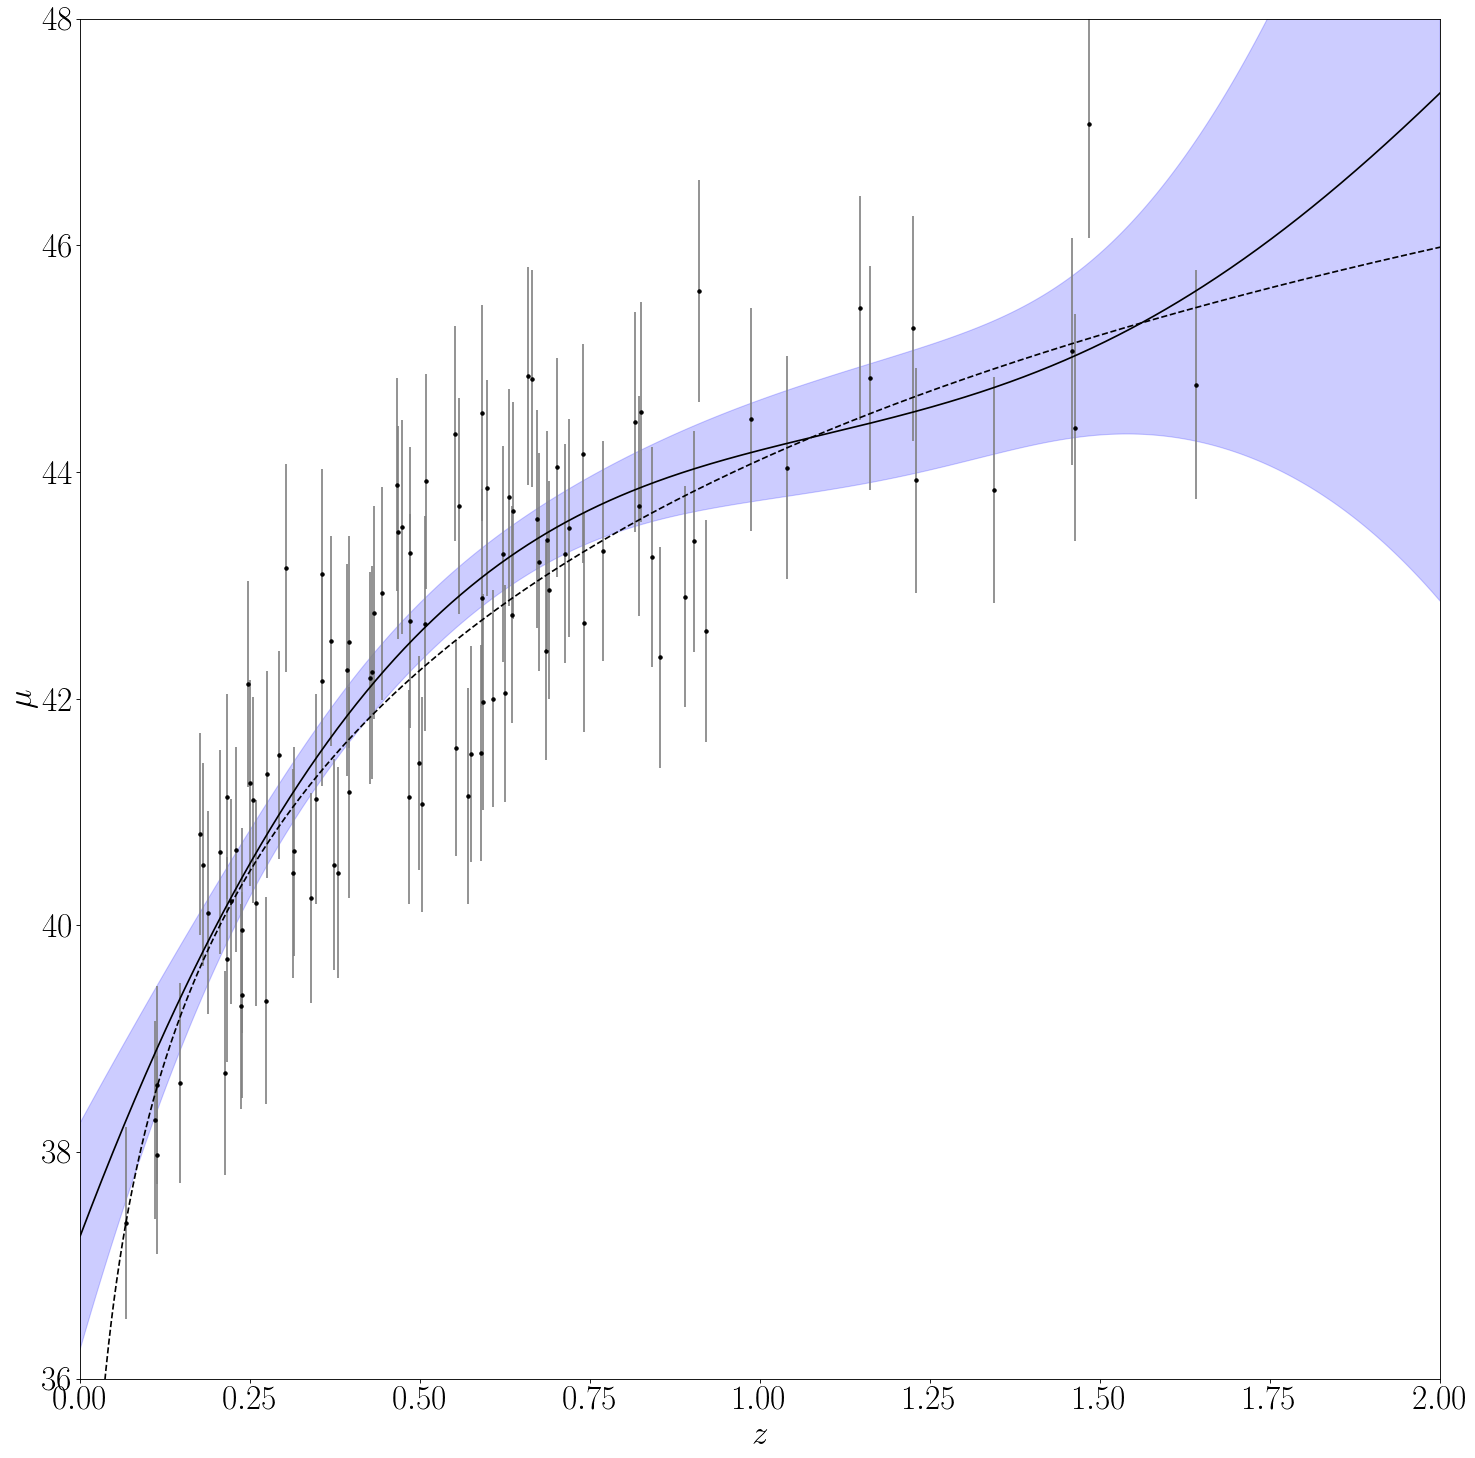

In [56]:
# Author: Jake VanderPlas
# License: BSD

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(list(map(cosmo.mu, z)))

#------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-2, thetaU=1,
                     normalize=False,
                     nugget=(dmu / mu_sample) ** 2,
                     random_start=1)
gp.fit(z_sample[:, None], mu_sample)
y_pred, MSE = gp.predict(z_fit[:, None], eval_MSE=True)
sigma = np.sqrt(MSE)
print(gp.theta_)


#------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
#fig = plt.figure(figsize=(5, 5))             #---- Figure is too small
fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

# <font color=blue> $\S8.11.$ Overfitting, Underfitting, and Cross-Validation </font>

### Overview:
If we do not know the form of the model of the process generating our data, the best (approximate) model we can select will be one that (1)<font color=purple> **minimizes the loss** (which favors greater model complexity/flexibility)</font> and (2) <font color=purple> **has the predictive power** (which favors generalization or less model complexity/flexibility)</font>.

### <font color=red> Bias-Variance Trade-Off </font>
Errors in a model come in two flavors: **reducible** (one which we can eliminate) and **irreducible** (inherent uncertainty due to the natural variability in the system itself). We want to select a model that minimizes reducible error, which can be futher classified into <font color=purple> **bias** </font> and <font color=purple> **variance**</font>. Selecting a model that is too simple will result in <font color=purple>*large bias*</font> due to <font color=red> **underfitting**</font>; the model is unable to capture the general trend in the data. Selecting a model that is too complex will result in <font color=purple>*large variance*</font> due to <font color=red> **overfitting**</font>. The best model will ensure the delicate balance between these two requirements. 


### Example:
Consider a data set of 20 points between $0 \leq x_i \leq 3$ that was generated by some process modeled by:
$$y_i = x_i \sin(x_i) + \epsilon_i$$
where the noise is characterized by $\epsilon \sim \mathcal{N}(0,0.1)$.

Our goal is to recover the best approximation of this model from a frequentist perspective. We will consider a 1st (line), 2nd (quadratic), 3rd (cubic), and 19th-ordered polynomials as the possible models that describe our data. We will choose a mean square error as our loss function:
$$\epsilon = \frac{1}{N} \sum\limits_{i=1}^N (y_i - y(x))^2$$

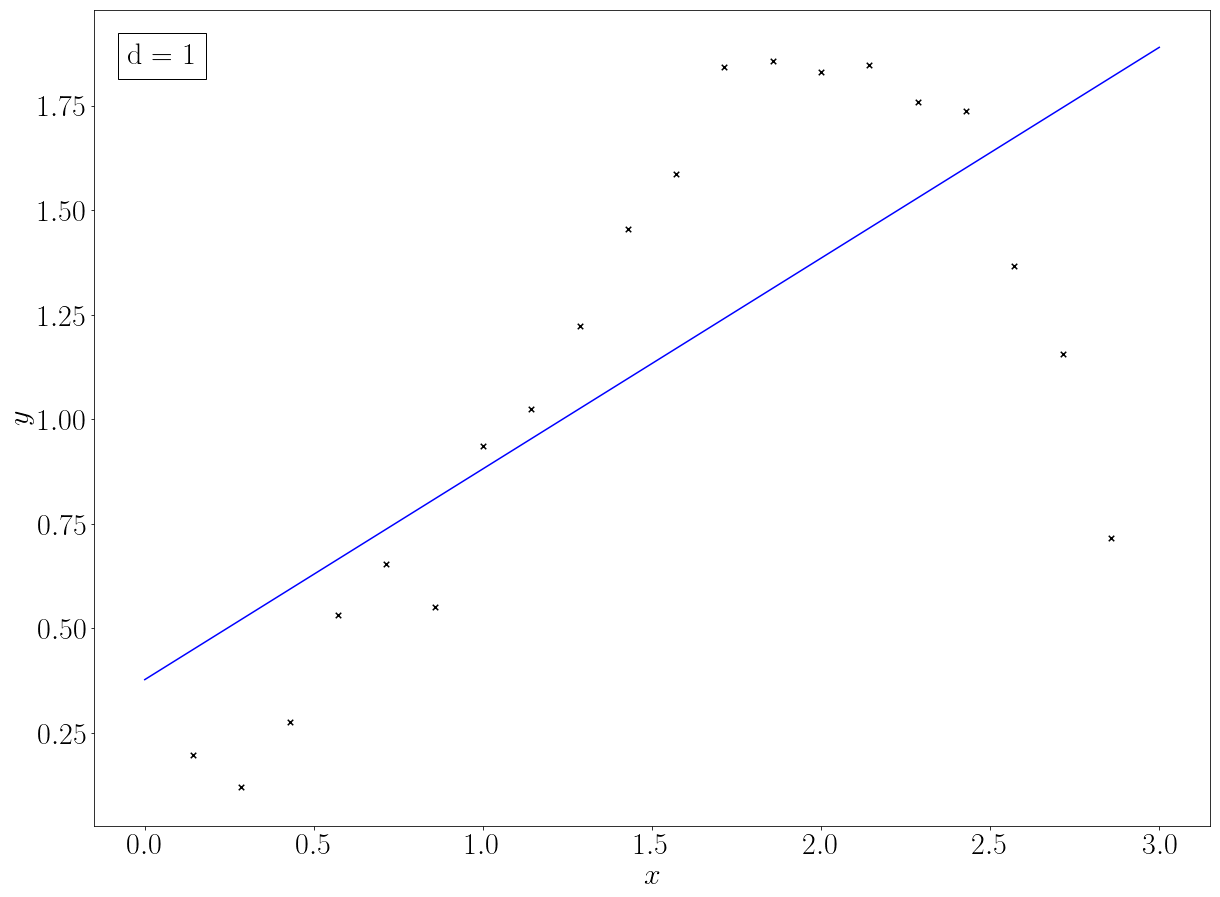

In [62]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# First figure: plot points with a linear fit
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)

ax.scatter(x, y, marker='x', c='k', s=30)

p = np.polyfit(x, y, 1)
y_fit = np.polyval(p, x_fit)

ax.text(0.03, 0.96, "d = 1", transform=plt.gca().transAxes,
        ha='left', va='top',
        bbox=dict(ec='k', fc='w', pad=10))

ax.plot(x_fit, y_fit, '-b')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

Fitting a line to the model does a poor job at capturing the general trend of the data. 

/Users/jennifer_kadowaki/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RankWarning: Polyfit may be poorly conditioned


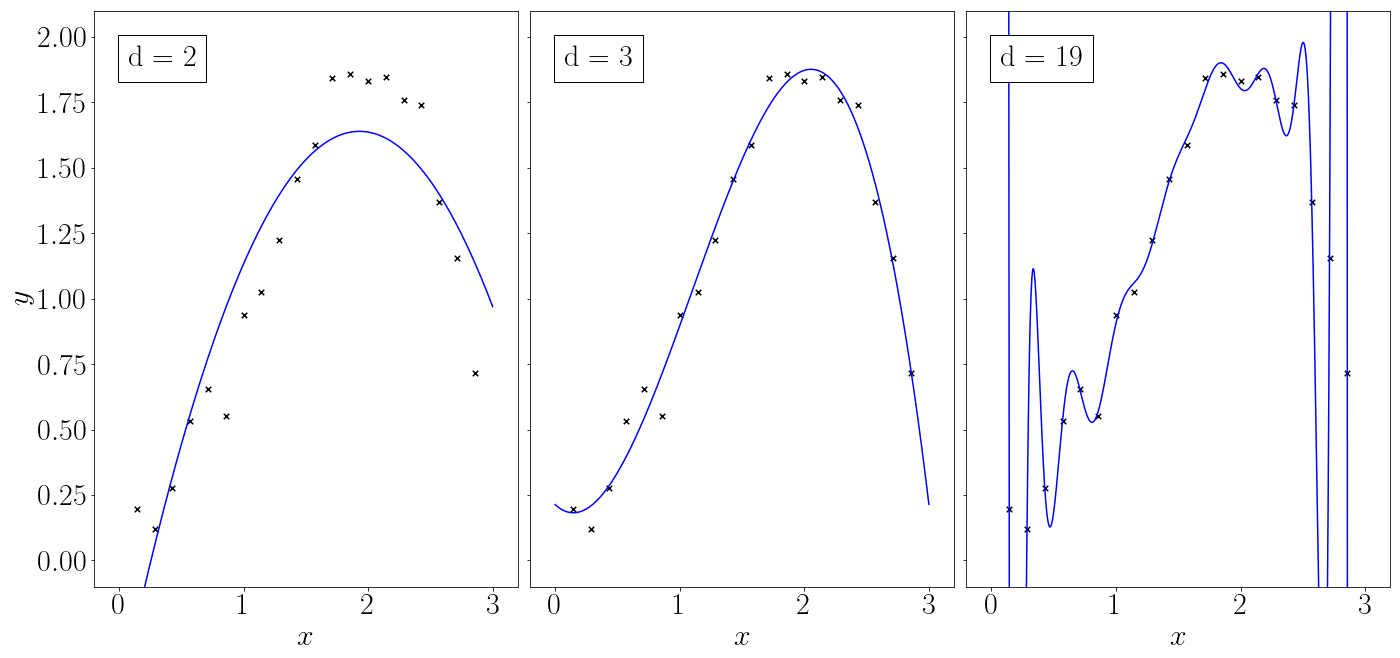

In [63]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Second figure: plot fit for several orders of polynomial
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([2, 3, 19]):
    ax = fig.add_subplot(131 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=10))

plt.show()

## <font color=green> $\S8.11.1.$ Cross-Validation </font>

### <font color=red> Purpose of CV </font>
1. <font color=purple> **Estimating model performance and predictive power** </font> on unseen data.
2. <font color=purple> **Selecting the most generalized model** </font> that captures the behavior of the data and avoids overfitting.


### <font color=red> Basic Recipe for CV </font>
1.  <font color=purple>**Split your data into 3 data sets**: the **training** set, the **cross-validation** set, and the **testing** set.</font>
The amount of data allocated to each set is highly dependent on your situation [i.e., how much data you (don't) have and the amount of computing power you have access to], which is outlined in $\S8.11.3$.

2. <font color=purple>**Use the data from your training set to estimate optimal model parameters for each model in consideration.**</font>
The error/loss associated with your training data and selected model is the training error for that model.

3. <font color=purple>**Use cross-validation to select the best model.**</font>
Compute the error/loss for each model. The model that minimizes the cross-validation loss should be selected.

4. <font color=purple>**Estimate the model performance with the testing data.**</font>
Estimate the performance by computing the loss on the training data. A separate testing set is recommended (as opposed to only having a cross-validation set) to prevent overfitting hyperparameters to your cross-validation set.

If you train a model over your entire data set then perform cross-validation, you cannot obtain an accurate estimate of the cross-validation error. [e.g., When you study for the astronomy written prelim exam, you study past prelim questions (especially those written by your exam committee members). If any of those questions repeat, you'd do a relatively good job at answering those questions since you've worked out the solution before. However, you most likely will not perform as well if all of the questions were entirely new. The latter case is a better representative of your understanding of the topic.]

#### General Rule of Thumb: <font color=purple> Allocate $50 - 70 \%$ of your data to the **training set**. Split the remainder evenly between the **cross-validation set** and the **testing set**</font>.



/Users/jennifer_kadowaki/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RankWarning: Polyfit may be poorly conditioned
/Users/jennifer_kadowaki/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RankWarning: Polyfit may be poorly conditioned
/Users/jennifer_kadowaki/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RankWarning: Polyfit may be poorly conditioned


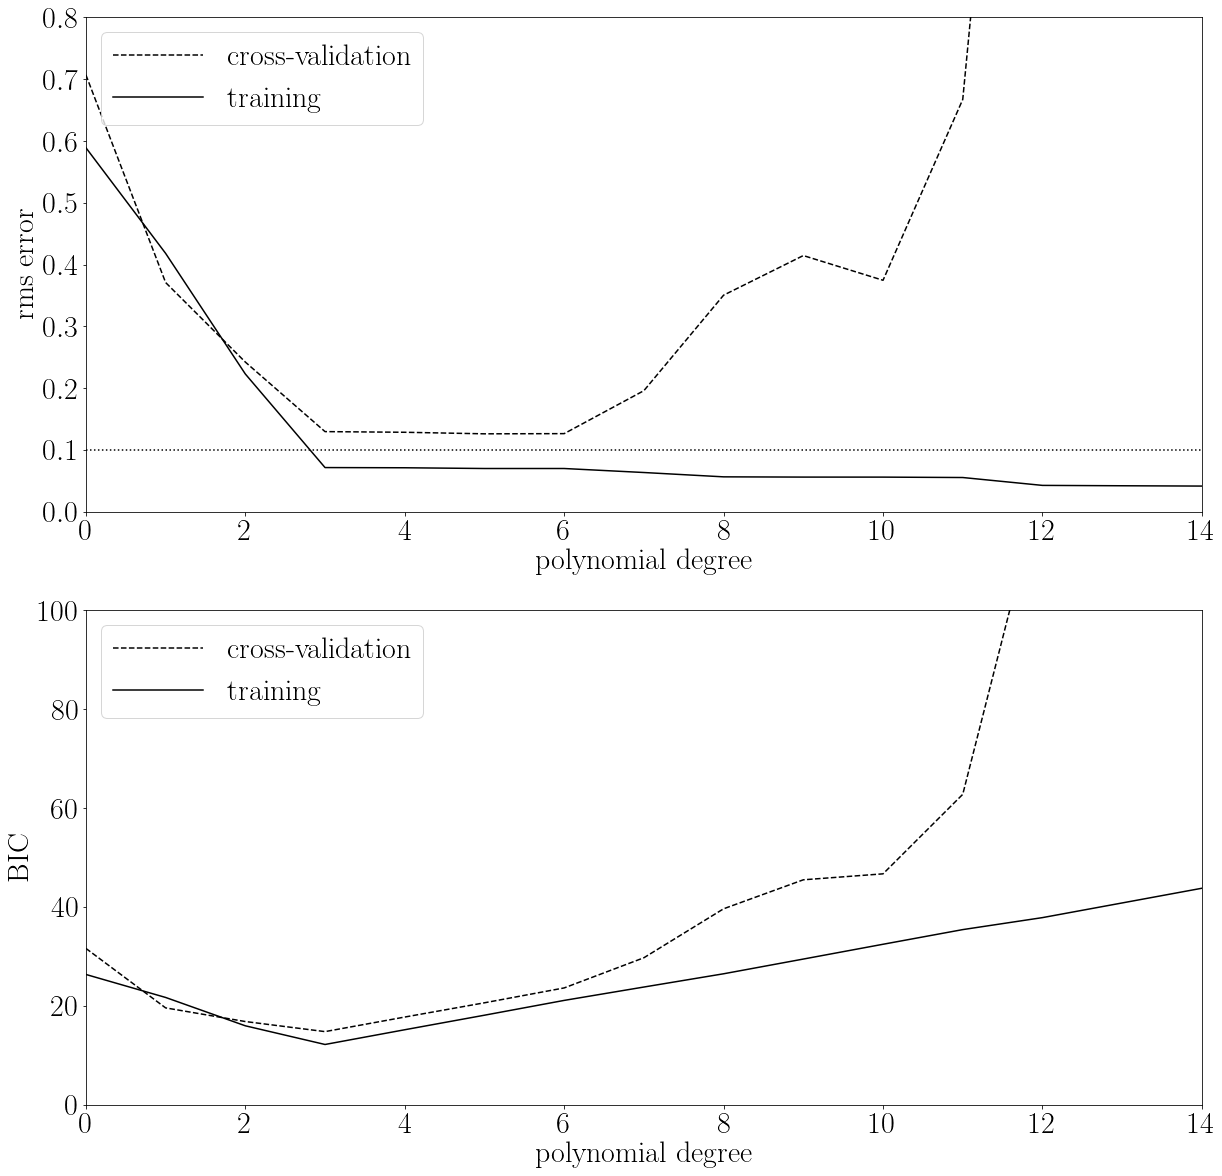

In [64]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(20, 20))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)
                              / len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))

BIC_train = np.sqrt(len(y)) * training_err / dy + d * np.log(len(y))
BIC_crossval = np.sqrt(len(y)) * crossval_err / dy + d * np.log(len(y))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()

## <font color=green> $\S8.11.2.$ Learning Curves </font>

For a given model, cross-validation does not directly inform us <font color=purple> **how we can improve our models** </font> if our cross-validation errors are much larger than known errors. The <font color=red> **learning curve** </font> plots the training and cross-validation errors against the number of points used in our training set to inform us <font color=red> **the effect of adding more training data**</font>. Learning curves help us determine the best approaches to improving our model from the following scenarios:

1. <font color=purple> **Acquire more training data** </font> 
2. <font color=purple> **Use more/less complicated data** </font> 
3. <font color=purple> **Use more/less regularization** </font> 
4. <font color=purple> **Increase the number of features** </font> 


To improve our models, consider the following situations & potential solutions:
1. <font color=red>**High Bias**</font>: <font color=purple>**Training Error & Cross-Validation Error Converge**</font>
   - Add additional features to the data
   - Increase the model complexity
   - Decrease the regularization


2. <font color=red>**High Variance**</font>: <font color=purple>**Training Error $\ll$ Cross-Validation Error**</font>
   - Increase the training set size
   - Decrease the model complexity
   - Increase the amplitude of the regularization

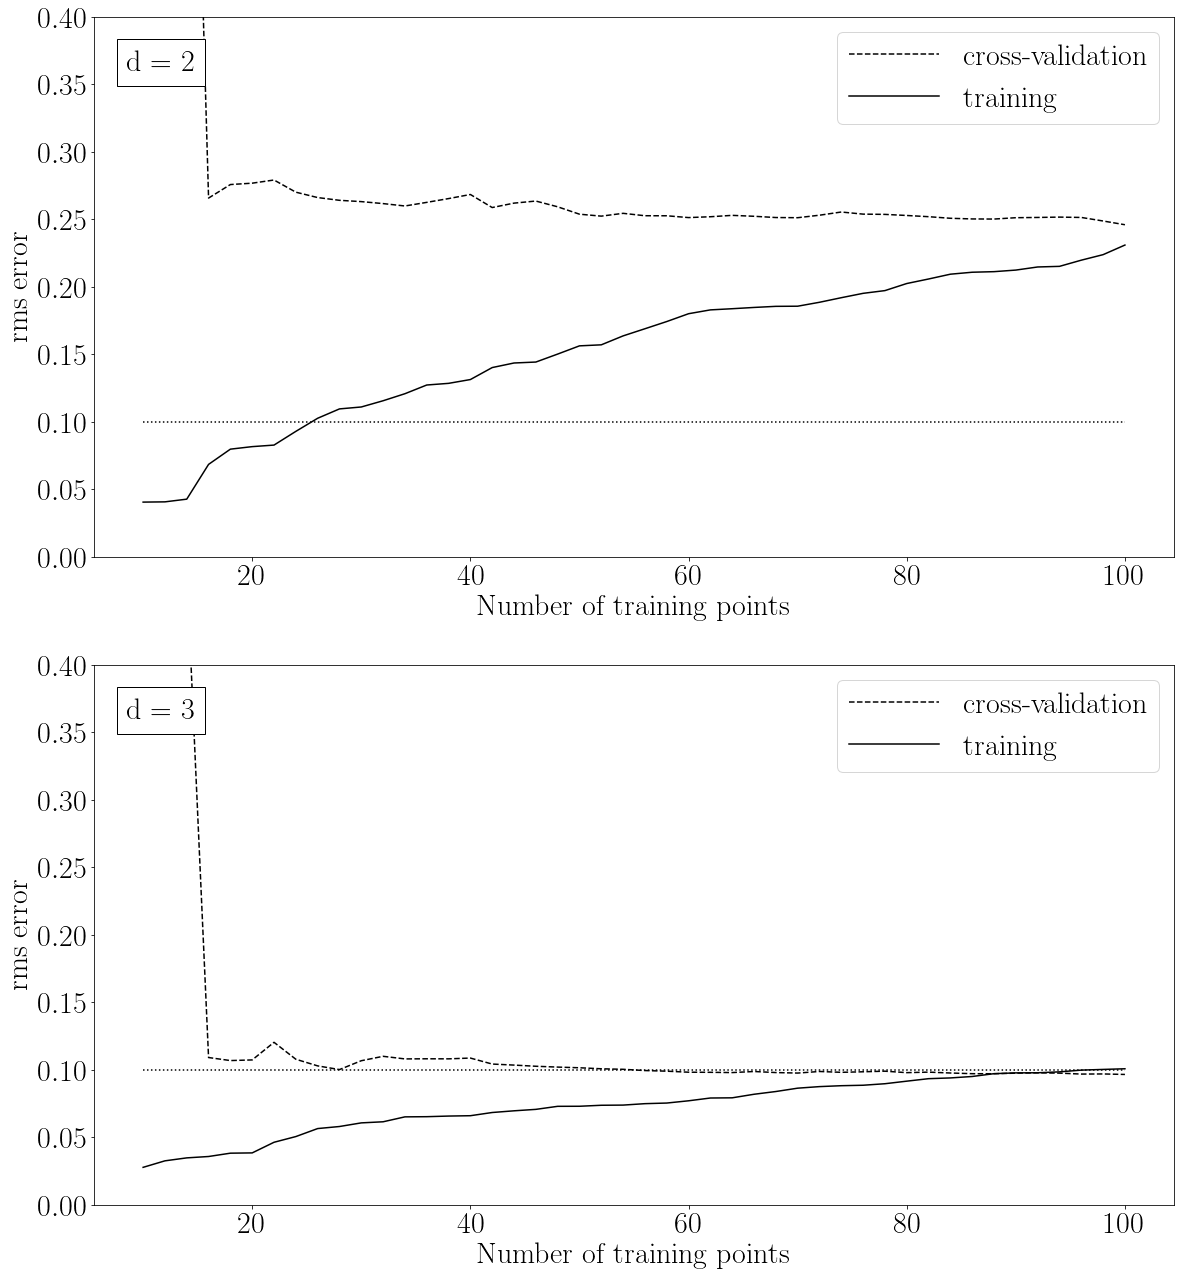

In [67]:
# Author: Jake VanderPlas
# License: BSD

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Fourth figure: plot errors as a function of training set size
np.random.seed(0)
x = 3 * np.random.random(100)
y = func(x)

np.random.seed(1)
x_cv = 3 * np.random.random(100)
y_cv = func(x_cv)

Nrange = np.arange(10, 101, 2)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0.15, top=0.95)

for subplot, d in zip([211, 212], [2, 3]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)

    for j, N in enumerate(Nrange):
        p = np.polyfit(x[:N], y[:N], d)
        training_err[j] = np.sqrt(np.sum((np.polyval(p, x[:N])
                                          - y[:N]) ** 2) / len(y))
        crossval_err[j] = np.sqrt(np.sum((np.polyval(p, x_cv)
                                          - y_cv) ** 2) / len(y_cv))

    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, 0.1 * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w', pad=10))

    ax.set_ylim(0, 0.4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()

## <font color=green> $\S8.11.3.$ Other Cross-Validation Techniques </font>

### <font color=red> 2-fold Cross-Validation </font>
2-fold CV is a specific form of k-fold CV, such that $k=2$.
(Generally, the more folds you have, the more computationally expensive CV becomes. For extremely large data sets, we want to minimize the number of folds we have. In machine learning, 10-fold cross validation is a popular choice. Personally, I think $k=2$ is extremely small.) 

### <font color=red> $K$-fold Cross-Validation </font>
$K$-fold CV is the most generalized version of CV. We split the data set equally into $k+1$ folds. One of the folds is set aside as our training data. On rest of the k-folds, we iterate through each fold and assign it as the cross-validata data while the model is trained on the remaining folds. We average the error from each iteration to obtain the cross-validation error. The model with the lowest average cross-validation error is selected and its performance is tested with the last fold, the training set.

### <font color=red> Leave-One-Out Cross-Validation </font>
Leave-one-out CV is a specific form of k-fold CV, such that $k=N$, the number of data points. We use LOOCV when we have small data sets and want to maximize the number of points we have to train our models.

### <font color=red> Random Subset Cross-Validation </font>
Random subset CV selects the cross-vaidation set and training set by repeatedly partitioning the data randomly until the error statistics are well sampled. Not all the data is guaranteed to be used.

## <font color=green> $\S8.11.4.$ Summary of Cross-Validation and Learning Curves </font>
We use cross-validation to estimate model performance and to select the best model that is general enough to provide useful predictions but complex enough to capture behavior of the data.

# Summary:    <font color=blue> $\S8.12.$ Which Regression Method Should I Use? </font>

### <font color=red> Properties of Different Regression Methods to Consider </font>
1. <font color=purple> **Accuracy**</font>: (In order of worst to best.)
   - **Linear Regression**
   
   - **Ridge / LASSO Regularization**:
     Linear regression with added penalty factor for model complexity. Linear regression is a special case of either when the penalty factor $\lambda = 0$. 
   
   - **PCA Regression**: Linear regression that treats collinearity and denoises the data.
   
   - **Linearization**: Accuracy depends on the sensibility of linearization transformation.
   
   - **Non-linear Regression**: More powerful due to its ability to incorporate non-linear variable interactions.

   - **Nadaraya-Watson Regression**: Non-parametric, kernel regression.
   
   - **Local Polynomial Regression**: More general, non-parametric, kernel regression.
   
   - **Gaussian Process Regression**: Incorporates aspects similar to kernal regression via the covariance matrix, but learns coefficients on each data point.
   
2. <font color=purple> **Interpretability**</font>: (Not in any particular order.)
   - **Linear Regression**: Easy to understand importance of each variable & model reaction to changing inputs
   - **Ridge / LASSO Regularization**: Increases interpretability by identifying most important features
   - **Bayesian Formulations**: Incorporates errors and makes assumptions clear.
   - **PCR**: Decreases interpretability. Columns are no longer identifiable.
   - **Linearization**: Transformation does not decrease interpretability.
   - **Non-linear Regression**: Hard to interpret.
   - **Kernel Regression**: Relatively interpretable. Behavior can be understood by distances between points.
   - **Gaussian Process Regression**: Hard to interpret behavior of the inverse covariance matrix.

3. <font color=purple> **Simplicity**</font>: (In order of best to worst.)
   - **Linear Regression**
   - **Linearization**: Similar to linear regression with preparation of non-linear parameters.
   - **Ridge / LASSO**: Requires 1 tuned parameter and convex optimization. No need for random restarts. Cross-validation allows for easy learning.
   - **PCR**: Requires 1 tuned parameter and convex optimization.
   - **Nadaraya-Watson Regression**: Only 1 critical parameter (i.e., bandwidth)
   - **General Local Polynomial Regression**: 2 parameters (i.e., bandwidth & polynomial order)
   - **Gaussian Process Regression**: 1 critical parameter (i.e., bandwidth of the covariance kernal) & convex.

4. <font color=purple> **Speed / Scalability**</font>: (In order of best to worst.)

   - **Linear regression / Ridge Regression / Linearization**: Fairly tractable with linear algebra assuming lower dimensionality.
   - **LASSO**: Requires solution of linear program. Expensive in high dimensions.
   - **PCA / SVD**: PCR
   - **Kernal Regression Methods**: $\mathcal{O}(N^2)$ but can be sped up by tree-based algorithms.
   - **Gaussian Process Regression**: $\mathcal{O}(N^3)$ & difficult to speed up while maintaining predictive accuracy.

5. <font color=purple> **Other factors to consider**</font>: 
   - Imputation
   - Errors/Uncertainty
   - Sparsity


### <font color=red> Summary of Properties for Different Regression Methods </font>

| Method                               | Accuracy | Interpretability | Simplicity | Speed |
| ------------------------------------ |:--------:|:----------------:|:----------:|:-----:|
| Linear Regression                    |     L    |         H        |      H     |   H   |
| Linear Basis Function Regression     |     M    |         M        |      M     |   M   |
| Ridge Regression                     |     L    |         H        |      M     |   H   |
| LASSO                                |     L    |         H        |      M     |   L   |
| PCA Regression                       |     M    |         M        |      M     |   M   |
| Nadaraya-Watson Regression           |    M/H   |         M        |      H     |  L/M  |
| Local Linear / Polynomial Regression |     H    |         M        |      M     |  L/M  |
| Nonlinear Regression                 |     M    |         H        |      L     |  L/M  |
